# Configs and Imports

In [1]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle

warnings.filterwarnings('ignore')

In [2]:
TARGET = 'Response'
N_FOLDS = 5
SEED = 90
ES_ROUNDS = 150
ES_LOG_STEPS = 50

TRAIN_PATH = '/kaggle/input/playground-series-s4e7/train.csv'
TEST_PATH = '/kaggle/input/playground-series-s4e7/test.csv'

# Loading and Processing The Datasets

In [3]:
class DataLoader:
    def __init__(self, path):
        self.path = path

    @staticmethod
    def encode_categorical_features(dataframe):  
        print('--- Encoding categorical features')
        dataframe = dataframe.copy()
        
        gender_mapping = {'Male': 0, 'Female': 1}
        vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
        vehicle_damage_mapping = {'No': 0, 'Yes': 1}
        
        dataframe['Gender'] = dataframe['Gender'].map(gender_mapping)
        dataframe['Vehicle_Age'] = dataframe['Vehicle_Age'].map(vehicle_age_mapping)
        dataframe['Vehicle_Damage'] = dataframe['Vehicle_Damage'].map(vehicle_damage_mapping)
        
        return dataframe
    
    @staticmethod
    def convert_data_types(dataframe):  
        print('--- Converting data types')
        dataframe = dataframe.copy()
        
        dataframe['Region_Code'] = dataframe['Region_Code'].astype(int) 
        dataframe['Annual_Premium'] = dataframe['Annual_Premium'].astype(int) 
        dataframe['Policy_Sales_Channel'] = dataframe['Policy_Sales_Channel'].astype(int) 
        
        return dataframe
    
    @staticmethod
    def add_features(dataframe):  
        print('--- Adding new features')
        dataframe = dataframe.copy()
        
        # Reference: https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution
        dataframe['Previously_Insured_Annual_Premium'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Annual_Premium'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Age'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Age'].astype(str))[0]
        dataframe['Previously_Insured_Vehicle_Damage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vehicle_Damage'].astype(str))[0]
        dataframe['Previously_Insured_Vintage'] = pd.factorize(dataframe['Previously_Insured'].astype(str) + dataframe['Vintage'].astype(str))[0]
        
        return dataframe
    
    @staticmethod
    def reduce_mem_usage(dataframe):
        # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516103#2899151
        
        print('--- Reducing memory usage')
        dataframe = dataframe.copy()
        initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype

            if col_type.name in ['category', 'object']:
                raise ValueError(f"Column '{col}' is of type '{col_type.name}'")

            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

        final_mem_usage = dataframe.memory_usage().sum() / 1024**2
        print('------ Memory usage before: {:.2f} MB'.format(initial_mem_usage))
        print('------ Memory usage after: {:.2f} MB'.format(final_mem_usage))
        print('------ Decreased memory usage by {:.1f}%'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))
        print(f'\nDataset size: {dataframe.shape}\n\n')

        return dataframe


    def load(self):
        print(f'Loading data from {self.path}')
        dataframe = pd.read_csv(self.path, index_col='id')
        
        dataframe = self.encode_categorical_features(dataframe)
        dataframe = self.convert_data_types(dataframe)
        dataframe = self.add_features(dataframe)
        dataframe = self.reduce_mem_usage(dataframe)
        
        return dataframe

In [4]:
train = DataLoader(TRAIN_PATH).load()
test = DataLoader(TEST_PATH).load()

X = train.drop(columns=TARGET)
y = train[TARGET]

Loading data from /kaggle/input/playground-series-s4e7/train.csv
--- Encoding categorical features
--- Converting data types
--- Adding new features
--- Reducing memory usage
------ Memory usage before: 1404.39 MB
------ Memory usage after: 351.10 MB
------ Decreased memory usage by 75.0%

Dataset size: (11504798, 15)


Loading data from /kaggle/input/playground-series-s4e7/test.csv
--- Encoding categorical features
--- Converting data types
--- Adding new features
--- Reducing memory usage
------ Memory usage before: 877.75 MB
------ Memory usage after: 226.75 MB
------ Decreased memory usage by 74.2%

Dataset size: (7669866, 14)




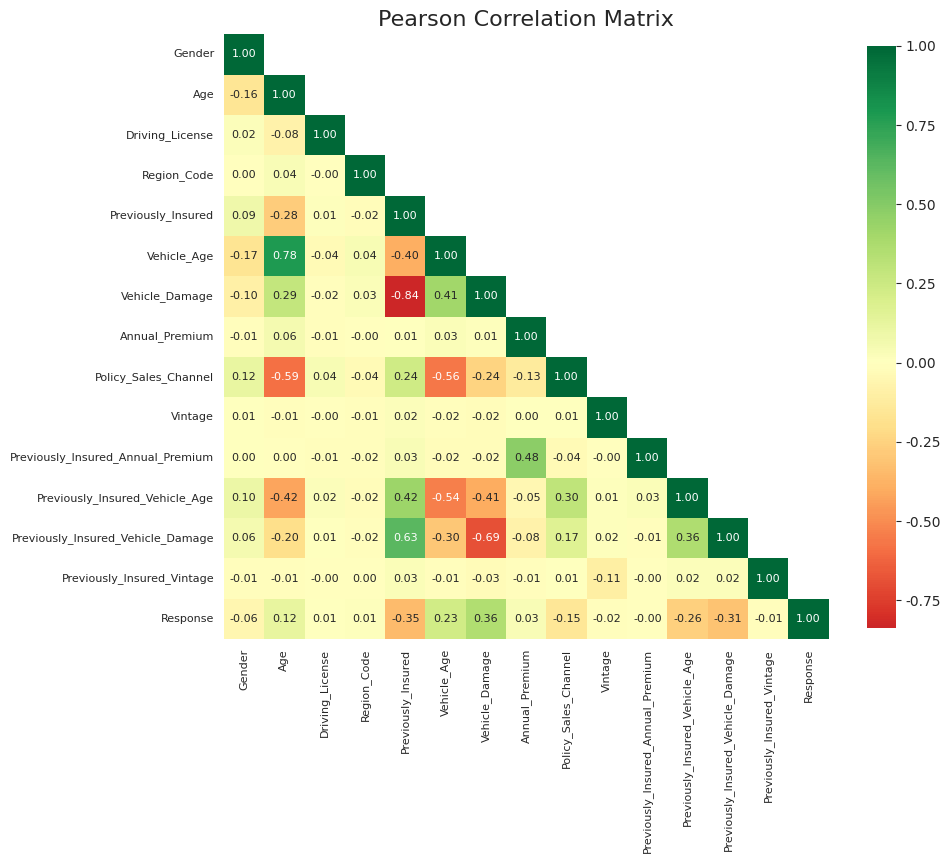

In [5]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 10))

cols = list(X.columns) + [TARGET]
temp_train = train[cols]

corr_train = temp_train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)
sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='RdYlGn',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax 
)

ax.set_title('Pearson Correlation Matrix', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

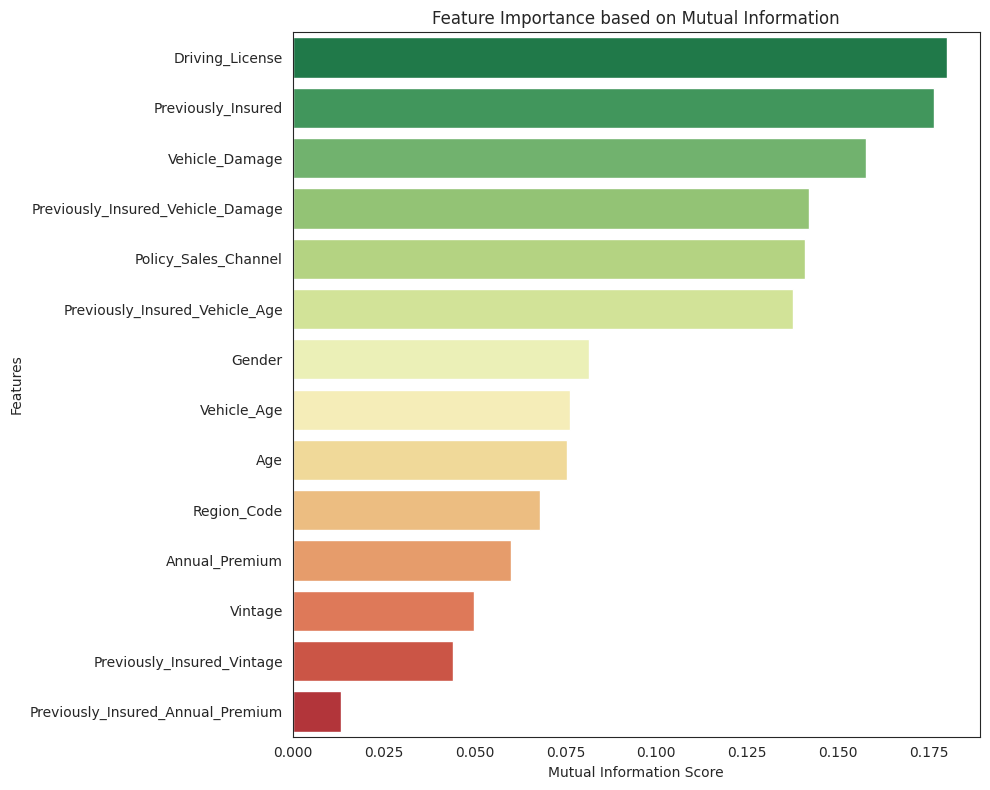

In [6]:
train_mi = train.copy()
train_mi = train.sample(1000_000)
X_mi = train_mi.drop(columns=TARGET)
y_mi = train_mi[TARGET]

mutual_info = mutual_info_classif(X_mi, y_mi, random_state=SEED)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.background_gradient('RdYlGn')

plt.figure(figsize=(10, 8))
sns.barplot(x=mutual_info['Mutual Information'], y=mutual_info.index, palette='RdYlGn_r')
plt.title('Feature Importance based on Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Training

In [7]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []
        feature_importances = np.zeros(X.shape[1])
        eval_history = []
        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        test_preds = []
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                verbose=ES_LOG_STEPS
            )
            
            feature_importances += model.feature_importances_ / self.n_folds
            eval_history.append(model.evals_result())
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs            
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            test_preds.append(temp_test_pred_probs[:, 1])
            
            score = roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)
            
            print(f'\n--- Fold {fold_idx + 1} - AUC: {score:.5f}\n\n')
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_preds, np.mean(scores))
        
        print(f'------ Average AUC:      {np.mean(scores):.5f} ± {np.std(scores):.5f}\n\n')

        return oof_pred_probs, scores, feature_importances, eval_history
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{model_name}_{name}_pred_probs_{cv_score:.5f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_preds, score):
        sub = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
        
        # Reference: https://www.kaggle.com/competitions/playground-series-s4e7/discussion/516269
        sub['id'] = sub['id'].astype(np.int32)
        sub[TARGET] = np.mean(test_preds, axis=0).astype(np.float16)
        
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub.to_csv(f'sub_{name}_{score:.5f}.csv', index=False)

In [8]:
params = {
    "colsample_bylevel": 0.21416299403295808,
    "colsample_bynode": 0.6208356380953189,
    "colsample_bytree": 0.19219680400212635,
    "early_stopping_rounds": 150,
    "eval_metric": "auc",
    "gamma": 0.6051664515971382,
    "max_bin": 682,
    "max_delta_step": 5.264818337431145,
    "max_depth": 68,
    "min_child_weight": 5.23408291542125,
    "n_estimators": 10000,
    "n_jobs": -1,
    "objective": "binary:logistic",
    "random_state": SEED,
    "reg_alpha": 0.46516016901463414,
    "reg_lambda": 0.8410553418334902,
    "subsample": 0.802533192662325,
    "verbosity": 0
}

model = XGBClassifier(**params)
trainer = Trainer(model)
oof_pred_probs, scores, feature_importances, eval_history = trainer.fit_predict(X, y, test)

Training XGBClassifier

[0]	validation_0-auc:0.54210
[50]	validation_0-auc:0.87091
[100]	validation_0-auc:0.88357
[150]	validation_0-auc:0.88490
[200]	validation_0-auc:0.88899
[250]	validation_0-auc:0.88899
[300]	validation_0-auc:0.88898
[350]	validation_0-auc:0.88899
[400]	validation_0-auc:0.88909
[450]	validation_0-auc:0.88913
[500]	validation_0-auc:0.88951
[550]	validation_0-auc:0.88998
[600]	validation_0-auc:0.88993
[650]	validation_0-auc:0.89001
[700]	validation_0-auc:0.89022
[750]	validation_0-auc:0.89026
[800]	validation_0-auc:0.89024
[850]	validation_0-auc:0.89026
[900]	validation_0-auc:0.89049
[950]	validation_0-auc:0.89050
[1000]	validation_0-auc:0.89047
[1050]	validation_0-auc:0.89049
[1100]	validation_0-auc:0.89054
[1150]	validation_0-auc:0.89067
[1200]	validation_0-auc:0.89069
[1250]	validation_0-auc:0.89069
[1300]	validation_0-auc:0.89069
[1350]	validation_0-auc:0.89074
[1400]	validation_0-auc:0.89074
[1450]	validation_0-auc:0.89074
[1471]	validation_0-auc:0.89074

--- Fo

# Visualizing The Results

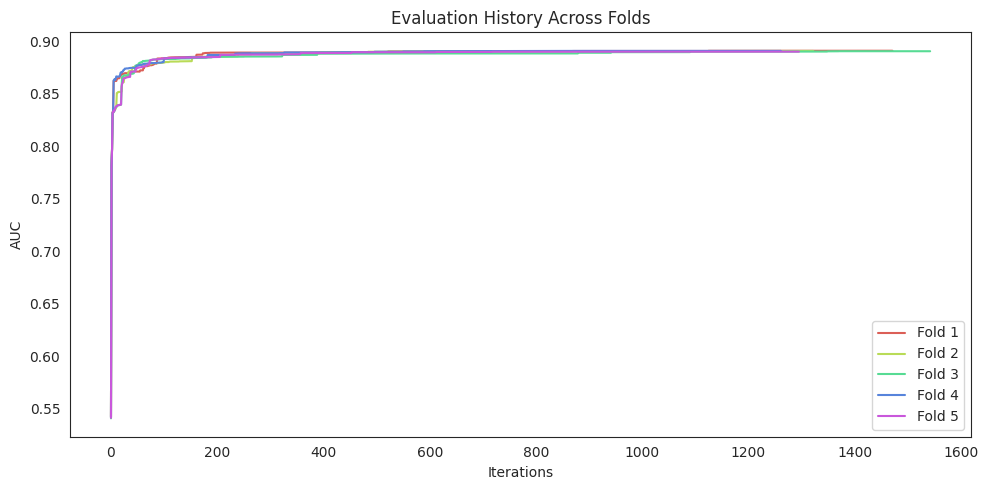

In [9]:
data = []
for fold_idx, fold_eval_history in enumerate(eval_history):
    for metric, values in fold_eval_history.items():
        for iteration, auc_value in enumerate(values['auc']):
            data.append({'Fold': f'Fold {fold_idx + 1}', 'Metric': metric, 'Iteration': iteration, 'AUC': auc_value})
df = pd.DataFrame(data)

plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Iteration', y='AUC', hue='Fold', palette='hls')
plt.title('Evaluation History Across Folds')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

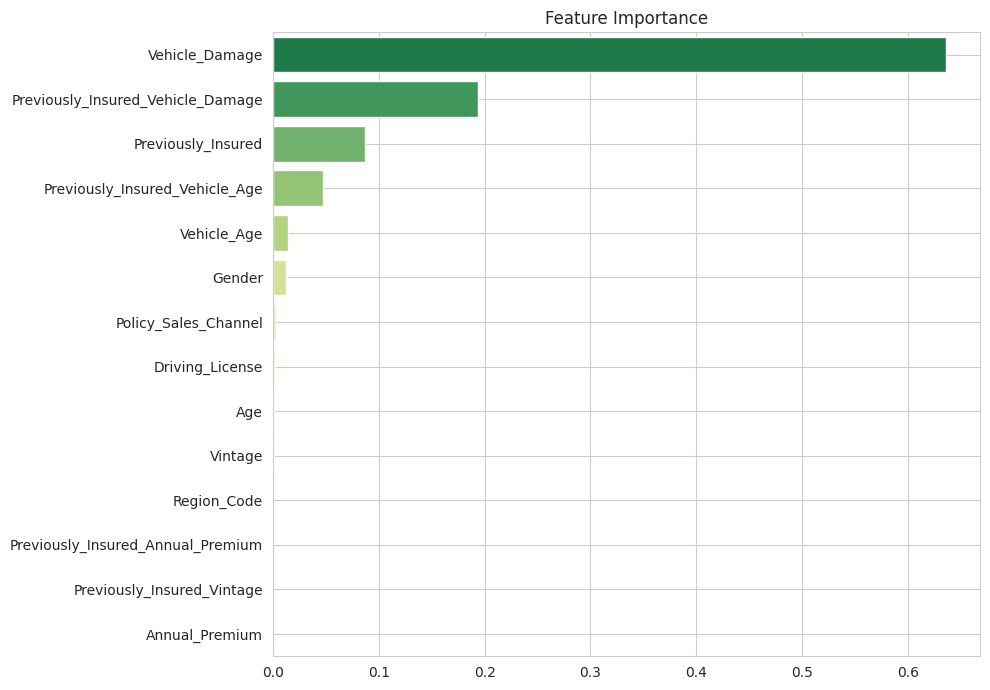

In [10]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 7))

fi = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
sns.barplot(
    y=fi.index, 
    x=fi.values, 
    orient='h', 
    palette=sns.color_palette('RdYlGn_r', len(X.columns))
)
plt.title('Feature Importance')
plt.grid(True)

plt.tight_layout()
plt.show()

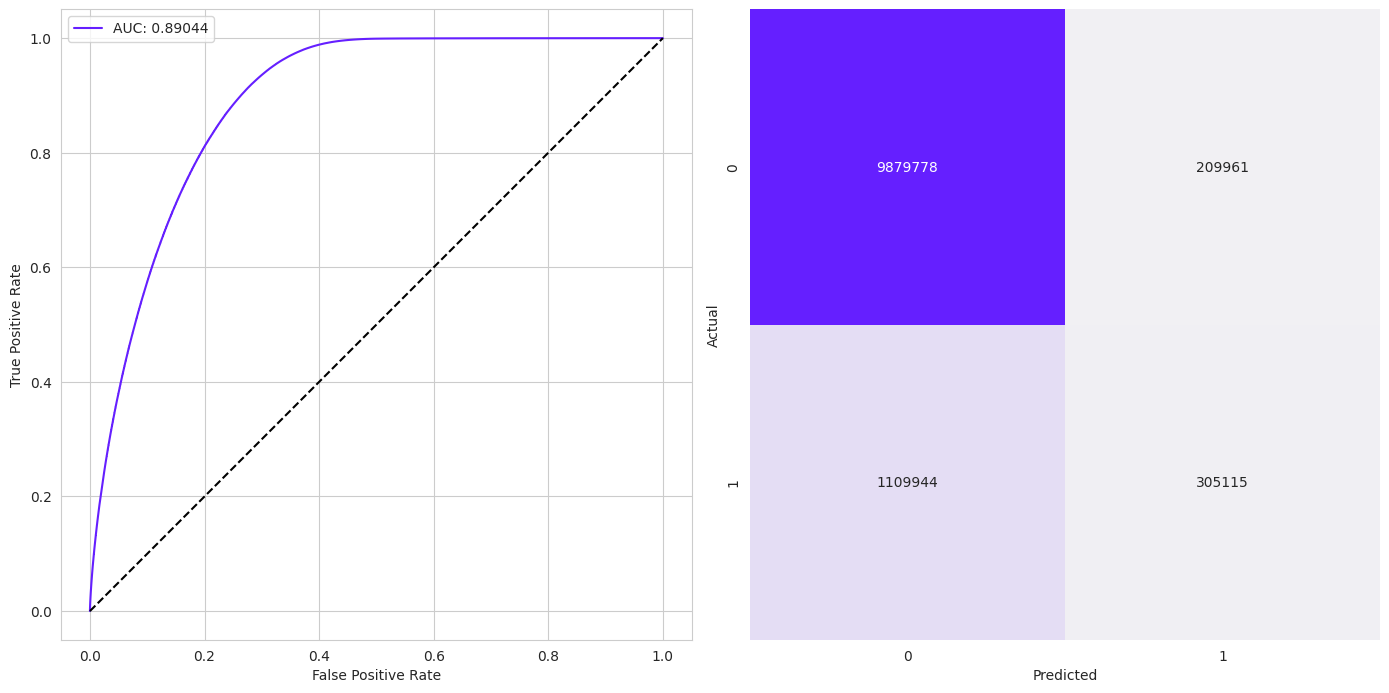

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, oof_pred_probs[:, 1])
axes[0].plot(fpr, tpr, label=f'AUC: {np.mean(scores):.5f}', color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = oof_pred_probs.argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()